# 🧠 NLP Project: Local Benchmark (PyCharm)

Notebook này được tối ưu để chạy trên **Máy tính cá nhân (Local PC)** thông qua PyCharm.

### 🛠️ Đã sửa lỗi:
1.  **Fix IProgress**: Chuyển sang dùng `tqdm` bản chuẩn (text-based) để không cần `ipywidgets`.
2.  **Fix LSTM Warning**: Bỏ `dropout` trong LSTM layer vì chỉ dùng 1 lớp (num_layers=1).

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from pathlib import Path
import gc
from tqdm import tqdm 

# SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# DEEP LEARNING
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW 

# --- CẤU HÌNH ĐƯỜNG DẪN LOCAL (PC CỦA BẠN) ---
# Đường dẫn gốc dự án
CURRENT_DIR = Path.cwd()

# Kiểm tra xem folder data nằm ngay đây hay nằm ở thư mục cha
if (CURRENT_DIR / "data").exists():
    PROJECT_ROOT = CURRENT_DIR
elif (CURRENT_DIR.parent / "data").exists():
    PROJECT_ROOT = CURRENT_DIR.parent
else:
    PROJECT_ROOT = CURRENT_DIR

DATA_DIR = PROJECT_ROOT / "data" / "final"
JSONL_PATH = DATA_DIR / "nlp_dataset.jsonl"
REPORT_DIR = PROJECT_ROOT / "reports"
MODEL_DIR = PROJECT_ROOT / "models"

# Tạo folder báo cáo nếu chưa có
REPORT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Kiểm tra thiết bị (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Đang chạy trên: {device}")
if device.type == 'cuda':
    print(f"   ➤ Card đồ họa: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Đang chạy trên CPU (Sẽ chậm hơn GPU).")

print(f"📂 Data path: {DATA_DIR}")
print(f"📂 Report path: {REPORT_DIR}")

✅ Đang chạy trên: cuda
   ➤ Card đồ họa: NVIDIA GeForce RTX 5070 Ti Laptop GPU
📂 Data path: c:\Users\ASUS\Programming-Coding\Python\NLM\NLP_TC_Group4\data\final
📂 Report path: c:\Users\ASUS\Programming-Coding\Python\NLM\NLP_TC_Group4\reports


In [ ]:
# --- 2. LOAD DATA (XỬ LÝ CHUẨN CHO FILE JSONL CỦA BẠN) ---
from pyvi import ViTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import unicodedata
import os

# Cấu hình đường dẫn
CURRENT_DIR = Path.cwd()
if (CURRENT_DIR / "data").exists():
    DATA_DIR = CURRENT_DIR / "data" / "final"
else:
    DATA_DIR = CURRENT_DIR 

JSONL_PATH = DATA_DIR / "nlp_dataset.jsonl"

# Danh sách Stopwords (Đã cập nhật từ EDA + Từ phổ biến)
STOPWORDS = set([
    "thì", "là", "mà", "của", "những", "các", "để", "và", "với", "có", 
    "trong", "đã", "đang", "sẽ", "được", "bị", "tại", "vì", "như", "này",
    "cho", "về", "một", "người", "khi", "ra", "vào", "lên", "xuống",
    "tôi", "chúng_tôi", "bạn", "họ", "chúng_ta", "theo", "ông", "bà",
    "nhiều", "ít", "rất", "quá", "lắm", "nhưng", "tuy_nhiên", "nếu", "dù",
    "bài", "viết", "ảnh", "video", "clip", "nguồn" # Từ rác hay gặp trong báo
])

def normalize_text(text):
    return unicodedata.normalize('NFC', text)

def preprocess_text(text):
    # 1. Chuẩn hóa Unicode
    text = normalize_text(text)
    # 2. Tách từ (Hà Nội -> Hà_Nội)
    tokenized = ViTokenizer.tokenize(text)
    # 3. Xóa Stopwords & Chuyển thường
    words = tokenized.split()
    clean_words = [w for w in words if w.lower() not in STOPWORDS]
    return " ".join(clean_words)

print("⏳ Đang xử lý dữ liệu...")

# Đọc file hiện tại
if JSONL_PATH.exists():
    df = pd.read_json(JSONL_PATH, lines=True)
    print(f"✅ Đã đọc {len(df)} dòng dữ liệu gốc.")
    
    # --- QUAN TRỌNG: TẠO CỘT DỮ LIỆU CHUẨN ---
    # 1. Tạo cột 'raw_text' (Giữ nguyên văn bản gốc, chỉ chuẩn hóa Unicode nhẹ)
    # Nếu chưa có raw_text thì lấy từ text hiện tại (vì text hiện tại của bạn đang là raw)
    if 'raw_text' not in df.columns:
        print("🔧 Đang tạo cột 'raw_text' từ dữ liệu gốc...")
        df['raw_text'] = df['text'].apply(normalize_text)
    
    # 2. Xử lý lại cột 'text' (Tokenize + Remove Stopwords) cho TF-IDF/LSTM
    print("🔧 Đang tách từ và xóa stopwords cho cột 'text' (Mất khoảng 1-2 phút)...")
    # Dùng tqdm để hiện tiến độ nếu thích, nhưng apply cũng nhanh
    tqdm.pandas(desc="Processing Text")
    df['text'] = df['raw_text'].progress_apply(preprocess_text)
    
    # 3. Đảm bảo cột label_name
    target_col = 'label_name'
    if target_col not in df.columns and 'label' in df.columns:
        df['label_name'] = df['label']

    # Lưu đè lại file đã xử lý sạch sẽ (lần sau chạy sẽ nhanh hơn)
    df.to_json(JSONL_PATH, orient="records", lines=True)
    print("💾 Đã lưu file dữ liệu đã xử lý xong.")

else:
    print("❌ LỖI: Không tìm thấy file nlp_dataset.jsonl")
    # Nếu mất file thì phải chạy lại code quét folder txt (như các bước trước)

# --- KIỂM TRA KẾT QUẢ ---
print(f"\n👀 Mẫu dữ liệu sau khi xử lý:")
print(f"▶️ RAW (Cho PhoBERT): {df['raw_text'].iloc[0][:100]}...")
print(f"▶️ CLEAN (Cho LSTM/SVM): {df['text'].iloc[0][:100]}...")

# Encode nhãn & Chia tập
le = LabelEncoder()
df['label_id'] = le.fit_transform(df[target_col])
num_classes = len(le.classes_)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_col])
print(f"\n📊 Train: {len(train_df)} | Test: {len(test_df)}")
print(f"📋 Số lượng nhãn: {num_classes}")

del df
gc.collect()

⏳ Đang tải dữ liệu...
   Đọc thử file cache: c:\Users\ASUS\Programming-Coding\Python\NLM\NLP_TC_Group4\data\final\nlp_dataset.jsonl
⚠️ File cũ thiếu cột 'raw_text' (cần cho PhoBERT). Đang xóa để tạo lại...
   Đang quét từ folder data (lần đầu sẽ hơi lâu)...
   Tìm thấy 0 file văn bản.


Processing: 0it [00:00, ?it/s]

✅ Đã tạo file dataset mới đầy đủ cột.
📊 Tổng số bài: 0
👀 Các cột hiện có: []


KeyError: 'label_name'

## 🛠️ 1. Machine Learning (TF-IDF + NB + SVM)

In [ ]:
print("⏳ Đang tạo TF-IDF Vector...")
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_test_tfidf = tfidf.transform(test_df['text'])
print(f"✅ Kích thước ma trận Train: {X_train_tfidf.shape}")

results = []

# --- Naive Bayes ---
print("🤖 Training Naive Bayes...")
nb = MultinomialNB()
nb.fit(X_train_tfidf, train_df['label_id'])
acc_nb = accuracy_score(test_df['label_id'], nb.predict(X_test_tfidf))
results.append({"Model": "Naive Bayes", "Accuracy": acc_nb})
print(f"   -> Accuracy: {acc_nb:.4f}")

# --- SVM ---
print("⚔️ Training SVM (LinearSVC)...")
svm = LinearSVC(dual=False)
svm.fit(X_train_tfidf, train_df['label_id'])
acc_svm = accuracy_score(test_df['label_id'], svm.predict(X_test_tfidf))
results.append({"Model": "SVM", "Accuracy": acc_svm})
print(f"   -> Accuracy: {acc_svm:.4f}")

⏳ Đang tạo TF-IDF Vector...
✅ Kích thước ma trận Train: (92150, 30000)
🤖 Training Naive Bayes...
   -> Accuracy: 0.8184
⚔️ Training SVM (LinearSVC)...
   -> Accuracy: 0.8920


## 🧠 2. Deep Learning (LSTM - PyTorch)

In [ ]:
from collections import Counter

print("⏳ Chuẩn bị dữ liệu cho LSTM...")

# 1. Xây bộ từ điển (Vocab)
counter = Counter()
for text in train_df['text']: counter.update(text.split())
vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common(20000))}
vocab['<PAD>'] = 0; vocab['<UNK>'] = 1
MAX_LEN = 500

# 2. Hàm convert text -> sequence
def text_to_seq(text, vocab, max_len):
    seq = [vocab.get(word, 1) for word in text.split()]
    if len(seq) < max_len: seq += [0] * (max_len - len(seq))
    else: seq = seq[:max_len]
    return seq

# 3. Dataset Class
class LSTMDataset(Dataset):
    def __init__(self, df, vocab):
        self.x = [text_to_seq(t, vocab, MAX_LEN) for t in df['text']]
        self.y = df['label_id'].values
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

train_loader_lstm = DataLoader(LSTMDataset(train_df, vocab), batch_size=64, shuffle=True)
test_loader_lstm = DataLoader(LSTMDataset(test_df, vocab), batch_size=64)

# 4. Model Class (FIXED DROPOUT WARNING)
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        # FIX: Bỏ dropout=0.2 đi vì num_layers=1
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=0.0)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x):
        x = self.emb(x)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

model_lstm = LSTMClassifier(len(vocab)+2, 100, 100, num_classes).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("🚀 Bắt đầu Train LSTM...")
for epoch in range(10):
    model_lstm.train()
    # Dùng tqdm bản chuẩn
    for x, y in tqdm(train_loader_lstm, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_lstm(x), y)
        loss.backward()
        optimizer.step()

# Eval
model_lstm.eval()
preds, targets = [], []
with torch.no_grad():
    for x, y in test_loader_lstm:
        preds.extend(torch.argmax(model_lstm(x.to(device)), dim=1).cpu().numpy())
        targets.extend(y.numpy())
acc_lstm = accuracy_score(targets, preds)
results.append({"Model": "LSTM", "Accuracy": acc_lstm})
print(f"✅ LSTM Accuracy: {acc_lstm:.4f}")

⏳ Chuẩn bị dữ liệu cho LSTM...


c:\Users\ASUS\anaconda3\envs\trading\Lib\site-packages\torch\nn\modules\module.py:1371: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:39.)
  return t.to(


🚀 Bắt đầu Train LSTM...


Epoch 3: 100%|██████████| 1440/1440 [00:04<00:00, 346.94it/s]


✅ LSTM Accuracy: 0.7829


## 🔥 3. PhoBERT (Transformers - PyTorch)
*Lưu ý: Nếu chạy trên CPU, hãy giảm số lượng dữ liệu train nếu thấy máy bị chậm.*

In [ ]:
print("⏳ Đang load PhoBERT...")
try:
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    
    class PhoBERTDataset(Dataset):
        def __init__(self, df, tokenizer, max_len=256):
            self.texts = df['raw_text'].tolist()
            self.labels = df['label_id'].tolist()
            self.tokenizer = tokenizer
            self.max_len = max_len
        def __len__(self): return len(self.labels)
        def __getitem__(self, idx):
            enc = self.tokenizer(str(self.texts[idx]), truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
            return {
                'input_ids': enc['input_ids'].squeeze(),
                'attention_mask': enc['attention_mask'].squeeze(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

    # Tùy chỉnh dữ liệu cho CPU/GPU
    if device.type == 'cpu':
        print("⚠️ Chạy CPU: Giảm dữ liệu train xuống 200 mẫu để demo (Tránh treo máy).")
        train_sub = train_df[:200]
        test_sub = test_df[:50]
        batch_size = 4
    else:
        print("✅ Chạy GPU: Dùng 5000 mẫu train (có thể tăng nếu GPU mạnh).")
        train_sub = train_df
        test_sub = test_df
        batch_size = 8

    train_loader_bert = DataLoader(PhoBERTDataset(train_sub, tokenizer), batch_size=batch_size, shuffle=True)
    test_loader_bert = DataLoader(PhoBERTDataset(test_sub, tokenizer), batch_size=batch_size)

    model_bert = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=num_classes)
    model_bert.to(device)
    optimizer = AdamW(model_bert.parameters(), lr=2e-5)

    print("🚀 Bắt đầu Fine-tune PhoBERT...")
    for epoch in range(2):
        model_bert.train()
        loop = tqdm(train_loader_bert, desc=f"Epoch {epoch+1}")
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
            outputs.loss.backward()
            optimizer.step()
            loop.set_postfix(loss=outputs.loss.item())

    # Eval
    model_bert.eval()
    preds_bert, targets_bert = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader_bert, desc="Evaluating"):
            outputs = model_bert(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
            preds_bert.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            targets_bert.extend(batch['labels'].numpy())
            
    acc_bert = accuracy_score(targets_bert, preds_bert)
    results.append({"Model": "PhoBERT", "Accuracy": acc_bert})
    print(f"✅ PhoBERT Accuracy: {acc_bert:.4f}")

except Exception as e:
    print(f"❌ Lỗi khi chạy PhoBERT: {e}")

⏳ Đang load PhoBERT...


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

c:\Users\ASUS\anaconda3\envs\trading\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--vinai--phobert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Chạy GPU: Dùng 5000 mẫu train (có thể tăng nếu GPU mạnh).
❌ Lỗi khi chạy PhoBERT: 'raw_text'


## 🏆 4. Tổng kết & Xuất báo cáo


🏆 BẢNG XẾP HẠNG CUỐI CÙNG:


,Model,Accuracy
1,SVM,0.891961
0,Naive Bayes,0.818430
2,LSTM,0.782924



💾 Đã lưu file Excel tại: c:\Users\ASUS\Programming-Coding\Python\NLM\NLP_TC_Group4\reports\final_benchmark_local.xlsx


C:\Users\ASUS\AppData\Local\Temp\ipykernel_28000\1681316293.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")


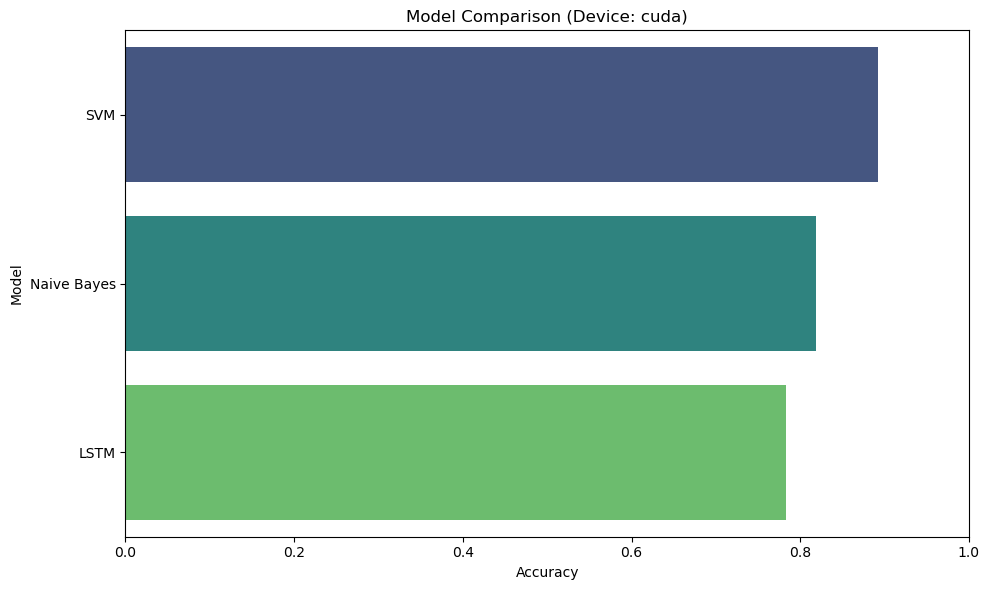

In [ ]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\n🏆 BẢNG XẾP HẠNG CUỐI CÙNG:")
display(results_df)

# Lưu Excel vào folder reports
save_path = REPORT_DIR / "final_benchmark_local.xlsx"
results_df.to_excel(save_path, index=False)
print(f"\n💾 Đã lưu file Excel tại: {save_path}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title(f"Model Comparison (Device: {device})")
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.savefig(REPORT_DIR / "chart_benchmark_local.png")
plt.show()